In [1]:
import sys
sys.path.insert(0, '/mnt/das-gpfs/home/ext-liekhussc_c/p17983/alvra_beamline_scripts/alvra_tools/')

In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
ploton = True

scan_name = "Febpy_monoscan_200mJ_5ps_001"

DIR = "/das/work/p17/p17983/Example_data/raw/scan_data/" + scan_name + "/"
DIR_json = "/das/work/p17/p17983/Example_data/res/scan_info/"

Set up the filters.  "numstds" is the number of standard deviations to take from the median.

In [4]:
numstds = 2
minIzero = 0.002

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])

print ("Processing",numFiles,"files")

DataFluo_pump_norm_total = np.empty(0)
DataFluo_unpump_norm_total = np.empty(0)
err_DataFluo_pump_total = np.empty(0)
err_DataFluo_unpump_total = np.empty(0)

IzeroFEL_pump_original_total = np.empty(0)
IzeroFEL_pump_total = np.empty(0)
IzeroFEL_unpump_original_total = np.empty(0)
IzeroFEL_unpump_total = np.empty(0)

DataFluo_pump_original_total = np.empty(0)
DataFluo_pump_total = np.empty(0)
DataFluo_unpump_original_total = np.empty(0)
DataFluo_unpump_total = np.empty(0)

Energy_eV = np.empty(0)

for i in range(0,numFiles):
#for i in range(0,3):
    filename = str(data['scan_files'][i][0])
    filename = '/mnt/das-gpfs/home/ext-liekhussc_c/p17983/Example_data/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/' \
                + os.path.basename(filename)
    exists = os.path.isfile(filename)
    if not exists:
        print("No such file")
    elif exists and i!=39:
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, Energy, \
         DataTrans_pump, DataTrans_unpump) = load_PumpProbe_events(filename, channel_energy)

        IzeroFEL_pump_original = IzeroFEL_pump.copy()
        IzeroFEL_unpump_original = IzeroFEL_unpump.copy()
        
        IzeroFEL_pump_original_total = np.append(IzeroFEL_pump_original_total, IzeroFEL_pump_original)
        IzeroFEL_unpump_original_total = np.append(IzeroFEL_unpump_original_total, IzeroFEL_unpump_original)
        
        DataFluo_pump_original_total = np.append(DataFluo_pump_original_total, DataFluo_pump)
        DataFluo_unpump_original_total = np.append(DataFluo_unpump_original_total, DataFluo_unpump)
        
        IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
        IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))

        conditionPumpMax = IzeroFEL_pump < IzeroMedian+numstds*IzeroSTD
        conditionPumpMin = IzeroFEL_pump > IzeroMedian-numstds*IzeroSTD
        conditionPumpLow = IzeroFEL_pump > minIzero

        conditionUnPumpMax = IzeroFEL_unpump < IzeroMedian+numstds*IzeroSTD
        conditionUnPumpMin = IzeroFEL_unpump > IzeroMedian-numstds*IzeroSTD
        conditionUnPumpLow = IzeroFEL_unpump > minIzero

        condIzeroPump = conditionPumpMax & conditionPumpMin & conditionPumpLow
        condIzeroUnPump = conditionUnPumpMax & conditionUnPumpMin & conditionUnPumpLow
        
        IzeroFEL_pump = IzeroFEL_pump[condIzeroPump]
        IzeroFEL_unpump = IzeroFEL_unpump[condIzeroUnPump]
        
        IzeroFEL_pump_total = np.append(IzeroFEL_pump_total, IzeroFEL_pump)
        IzeroFEL_unpump_total = np.append(IzeroFEL_unpump_total, IzeroFEL_unpump)
        
        DataFluo_pump = DataFluo_pump[condIzeroPump]
        DataFluo_unpump = DataFluo_unpump[condIzeroUnPump]
        
        DataFluo_pump_total = np.append(DataFluo_pump_total, DataFluo_pump)
        DataFluo_unpump_total = np.append(DataFluo_unpump_total, DataFluo_unpump)
        
        DataFluo_pump_norm = DataFluo_pump/IzeroFEL_pump
        DataFluo_unpump_norm = DataFluo_unpump/IzeroFEL_unpump
        
        DataFluo_pump_norm_total = np.append(DataFluo_pump_norm_total, DataFluo_pump_norm.mean())
        DataFluo_unpump_norm_total = np.append(DataFluo_unpump_norm_total, DataFluo_unpump_norm.mean())
        err_DataFluo_pump_total = np.append(err_DataFluo_pump_total, DataFluo_pump_norm.std()/np.sqrt(DataFluo_pump_norm.size))
        err_DataFluo_unpump_total = np.append(err_DataFluo_unpump_total, DataFluo_unpump_norm.std()/np.sqrt(DataFluo_unpump_norm.size))
        
        Energy = [x for x in Energy if (np.abs(x) > 0)]
        Energy_eV = np.append(Energy_eV, np.mean(Energy))
        
        

/das/work/p17/p17983/Example_data/res/scan_info/Febpy_monoscan_200mJ_5ps_001_scan_info.json
Processing 61 files
step 1 of 61 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0000.BSREAD.h5
step 2 of 61 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0001.BSREAD.h5
step 3 of 61 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0002.BSREAD.h5
step 4 of 61 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0003.BSREAD.h5
step 5 of 61 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0004.BSREAD.h5
step 6 of 61 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0005.BSREAD.h5
step 7 of 61 : Processing /sf/alvra/data/p17589/raw/sc

step 60 of 61 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0059.BSREAD.h5
step 61 of 61 : Processing /sf/alvra/data/p17589/raw/scan_data/Febpy_monoscan_200mJ_5ps_001/Febpy_monoscan_200mJ_5ps_001_step0060.BSREAD.h5


Plot some diagnostics

The original number of pumped and unpumped shots is:
(30000,) (30000,)
The filtered number of pumped and unpumped shots is:
(27998,) (27940,)


<IPython.core.display.Javascript object>


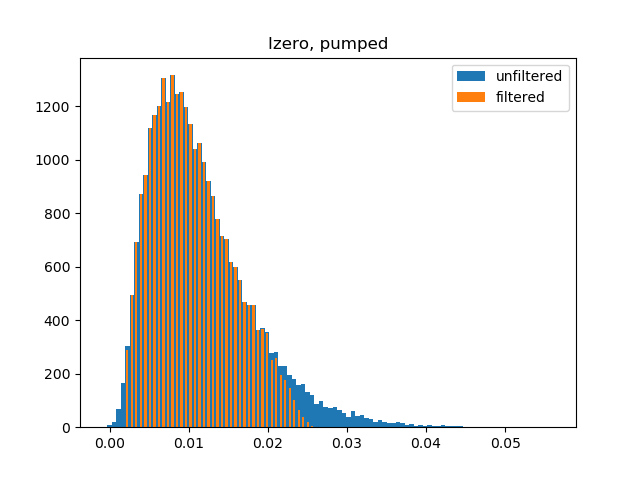

<IPython.core.display.Javascript object>


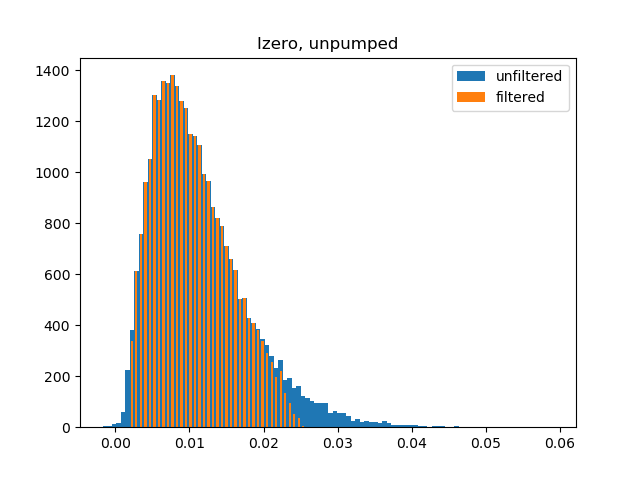

In [5]:
print("The original number of pumped and unpumped shots is:")
print(IzeroFEL_pump_original_total.shape, IzeroFEL_unpump_original_total.shape)
print("The filtered number of pumped and unpumped shots is:")
print(IzeroFEL_pump_total.shape, IzeroFEL_unpump_total.shape)

plt.figure()
_, bins, _ = plt.hist(IzeroFEL_pump_original_total, 100, label = 'unfiltered')
_ = plt.hist(IzeroFEL_pump_total, bins, rwidth = .5, label = 'filtered')
plt.title('Izero, pumped')
plt.legend()

plt.figure()
_, bins, _ = plt.hist(IzeroFEL_unpump_original_total, 100, label = 'unfiltered')
_ = plt.hist(IzeroFEL_unpump_total, bins, rwidth = .5, label = 'filtered')
plt.title('Izero, unpumped')
plt.legend()

<IPython.core.display.Javascript object>


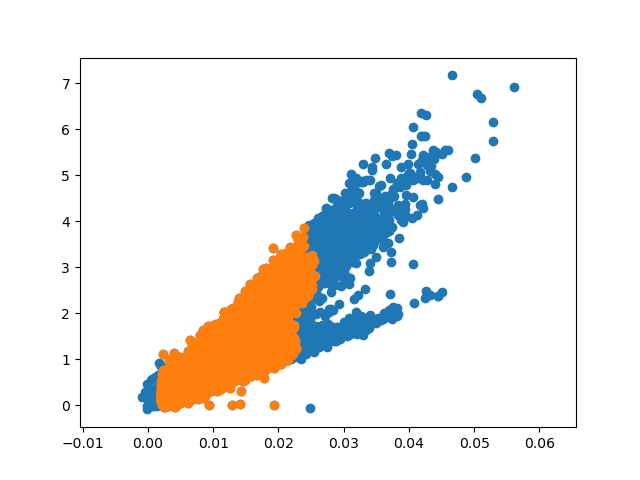

In [6]:
#IzeroFEL_pump_original_total = np.empty(1)
#IzeroFEL_pump_total = np.empty(1)
#IzeroFEL_unpump_original_total = np.empty(1)
#IzeroFEL_unpump_total = np.empty(1)

#DataFluo_pump_original_total = np.empty(1)
#DataFluo_pump_filtered_total = np.empty(1)
#DataFluo_unpump_original_total = np.empty(1)
#DataFluo_unpump_filtered_total = np.empty(1)

plt.figure()
plt.scatter(IzeroFEL_pump_original_total, DataFluo_pump_original_total)
plt.scatter(IzeroFEL_pump_total, DataFluo_pump_total)

<IPython.core.display.Javascript object>


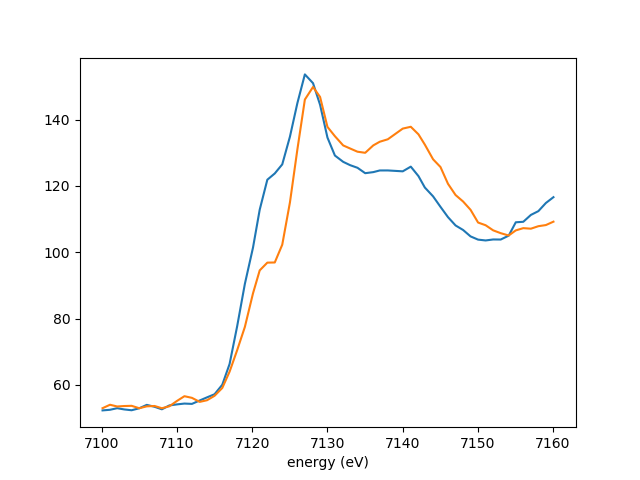

Text(0.5, 0, 'energy (eV)')

In [8]:
plt.figure()
plt.plot(np.array(Energy_eV), DataFluo_pump_norm_total)
plt.plot(np.array(Energy_eV), DataFluo_unpump_norm_total)
plt.xlabel('energy (eV)')